## Running the notebook
All code and program dependencies such as pythia, rivet, hepmc, Ax are preinstalled on the docker image `alialkadhim/pythia_sbi_tune:latest`. Here is how to install the image and run this notebook:

```
git clone https://github.com/AliAlkadhim/Pythia8_SBI_Tune.git
```
Then,
```
cd Pythia8_SBI_Tune/code/BayesOpt
bash docker_run.sh
```

Then, inside the docker container, do

```
jupyter-lab --ip 0.0.0.0 --port 8889 --allow-root &
```

Now copy and paste the link displayed at the bottom of the terminal to your browser.

----

This notebook performs Bayesian Optimizaion using GPytorch of the Lund string model parameters that appear in the fragmentation function

$$
f_{\text{Lund}}(z) \propto \frac{1}{z^{1+r_Q b m_Q^2}}(1-z)^{a'_i} \exp \left(-\frac{b m_{\perp}^2}{z}\right),
$$

As well as other important flavor and shower parameters. For detailed description of these parameters, see my overleaf writeup.

We use the data from `ALEPH_1996_S3486095` from the paper ["Studies of quantum chromodynamics with the ALEPH detector"](https://www.sciencedirect.com/science/article/pii/S0370157397000458)


## Key Observations
The default values of these parameters in pythia is due to the [Monash Tune](https://arxiv.org/pdf/1404.5630.pdf). Other papers have corroborated the results of that tune and attained similar values for some of the parameters. Therefore, when performing the Bayesian Optimization, we want to take that into account by forcing the algorithm to sample the Monash tune point. Observe how with few number of iterations, while forcing the sobol quasirandom sampling to explore the Monash tune, we will most likely end up with the Monash tune as the best-fit point. However, when we increase the number of iterations, we arrive at a tune that is slightly different than the Monash tune.

In [1]:
import numpy as np
from scipy.stats import qmc
import torch
import gpytorch
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.distributions import MultivariateNormal
import matplotlib.pyplot as plt

#`source /cvmfs/sft.cern.ch/lcg/views/LCG_102/x86_64-centos7-gcc11-opt/setup.sh`
from glob import glob
from tqdm import tqdm
import yoda2numpy_BayesOpt
from yoda2numpy_BayesOpt import Yoda2Numpy

import pythia_SBI_utils
from pythia_SBI_utils import *

FONTSIZE = 14
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
MAX_PROB = 4.0
PARAM_DICT = {
        # 'StringZ:aLund' : [0, 2.0],
        'StringZ:bLund': [0.2, 2.0],
        # 'StringZ:rFactC':[0.0, 2.0],
        # 'StringZ:rFactB': [0., 2.0],
        # 'StringZ:aExtraSQuark':[0.,2.],
        # 'StringZ:aExtraDiquark':[0.,2.],
        # 'StringPT:sigma':[0.,1.],
        # 'StringPT:enhancedFraction':[0.,1.],
        # 'StringPT:enhancedWidth':[1.0,MAX_PROB],
        # 'StringFlav:ProbStoUD':[0,MAX_PROB],
        # 'StringFlav:probQQtoQ':[0,MAX_PROB],
        # 'StringFlav:probSQtoQQ':[0,MAX_PROB],
        # 'StringFlav:ProbQQ1toQQ0':[0,MAX_PROB],
        # 'TimeShower:alphaSvalue':[0.06,0.25],
        # 'TimeShower:pTmin':[0.1,2.0]


}

MONASH_DICT = {
    # "aLund" : 0.68, 
    "bLund" : 0.98,
    # "rFactC": 1.32,
    # "rFactB":0.855,
    # "aExtraSQuark": 0.0,
    # "aExtraDiquark":0.97,
    # "sigma":0.335,
    # "enhancedFraction":0.01,
    # "enhancedWidth":2.0,
    # "ProbStoUD":0.217,
    # "probQQtoQ":0.081,
    # "probSQtoQQ":0.915,
    # "ProbQQ1toQQ0": 0.0275,
    # "alphaSvalue": 0.1365,
    # "pTmin": 0.5
}

REDUCED_MONASH_DICT = {
    # "aLund" : 0.68, 
    "bLund" : 0.98,
    # "aExtraSQuark": 0.0,
    # "sigma":0.335,
    # "enhancedFraction":0.01,
    # "ProbStoUD":0.217,
    # "probQQtoQ":0.081,
    # "probSQtoQQ":0.915,
    # "alphaSvalue": 0.1365,
    # "pTmin": 0.5
}


def get_param_prefix(param):
    for key,val in PARAM_DICT.items():
        prefix, postfix = key.split(':')
        if postfix == str(param):
            return prefix

param_names = list(PARAM_DICT.keys())
print(len(PARAM_DICT))

1


## Considererations for Data and Effective counts
Notice (unfortunately) that the total effective counts for every histogram is different! This is a huge complication because, in principle, we would need to generate different numbers of events for every histogram. But, as is true of much of what we do in science, we should make some simplifying assumptions to reduce to complexity of the problem. 

**Assumptions**

  1. Since we are not given correlation matrices for the measured cross sections, we assume that the bin-by-bin cross section measurements are conditionally independent: given fixed values of the tune parameters the measured cross sections are statistically independent.
  2. The counts per bin are Poisson-distributed and the cross sections are just scaled values of the counts.  We can, therefore, compute the effective count in each bin using the following *ansatz*
\begin{align}
    n_i & = k_i \sigma_i,\\
    \sqrt{n_i} & = k_i \delta \sigma_i \quad \text{and, therefore, }\\
    n_i & = \left( \frac{\sigma_i}{\delta\sigma_i} \right)^2 ,
\end{align}
where $\sigma_i \pm \delta\sigma_i$ is the measured cross section in bin $i$ and $k_i$, the *effective integrated luminosity*, is the product $\epsilon_i {\cal L}$ of the efficiency times acceptance, $\epsilon_i$, and  the integrated luminosity ${\cal L}$. The total effective count for a histogram is then just $n = \sum_{i} n_i$.

Therefore, for each tune parameter point, a sufficiently large sample of simulated events will result in histograms that serve both as the predictions as well as the basis for simulating events counts in all the simulated "observed" histograms. Given our assumptions, we can write down an approximation of the statistical model, $p(X | \theta)$, where $X$ are *potentially observable* counts and $\theta$ are the tune parameters. With the assumptions above, the statistical model for the $\texttt{ALEPH}$ data can be approximated as a product of either gamma or Gaussian densities depending on the size of the effective bin counts. We see that about 300,000 events need to be simulated per point in order to match the statistical precision of the data.

## .yoda format
The .yoda histograms for the data look like:

```
# xval	 xerr-	 xerr+	 yval	 yerr-	 yerr+
```
`xval` is the bin center, while `yval` is the height of the bin center. `xerr-=xerr+` is the positive and uncertainties in the bin center location, and `yerr-=yerr+` is the uncertainty in the height.

The data recorded is the cross section. so let's call that cross section in bin i $\hat{\sigma}_i^{Data} =yval$ and the uncertainty in bin i $\Delta^{Data}_i = yerr-$ . 


while the simulation histograms look like:
```
xlow	 xhigh	 sumw	 sumw2	 sumwx	 sumwx2	 numEntries
```

`xlow` is the left edge and `xhigh` is the right edge for a bin $i$. `sumw` is the sum of weights per bin $i$ $sumw^{bin, i} \sum_{k=1}^{N_{counts \ in \ bin \ i}} w_k^{bin \ i}$ and `sumw2` is sum of weights squared $sumw2^{bin \ i}=\sum_{k=1}^{N_{counts \ in \ bin \ i}} (w_k^{bin \ i})^2$ . To convert to differential cross section we divide by the bin widths, i.e. we calculate $\Delta x = xhigh-xlow$ and divide $\hat{\sigma}_i^{MC} = sumw/\Delta x$ and $sumw2/\Delta x ^2$ and $sumwx/\Delta x$ and $sumwx2/Delta x^2$ . Then the MC error for the cross section per bin is $\Delta_i^{MC} =\sqrt{sumw2/\Delta x ^2}$ 

We can write the effective count can be as
$$\frac{\sqrt{\sum_i w_i^2}}{\sum_i w_i}=\frac{1}{\sqrt{N_{e f f}}}$$
So 
$$N_{eff,\ i} = \left( \frac{\sum_i w_i }{\sqrt{\sum_i w_i^2 } } \right)^2 = \left( \frac{\sum_i w_i}{\Delta_{i, MC}} \right)^2$$
Therefore the scale factor per bin is

$$K_i = \frac{\sum_i w_i}{\sum_i w_i^2 }= \frac{\sum_i w_i}{\Delta_{i,MC}^2}$$

------

We use the following test statistic
$$
    \lambda(X; \theta) = \sqrt{\frac{1}{N}\sum_\text{histograms} \sum_i \left( \frac{D_i - T_i(\theta)}{\delta_i} \right)^2},
$$
where $N$ is the total number of bins summed over histograms and $\delta_i^2$ is the sum of the variances associated with the data $D_i$ and the theoretical prediction $T_i$ with the latter obtained via Monte Carlo simulation.

In [37]:
def make_pythia_card(
                    # aLund, 
                     bLund,
                    # rFactC,
                    # rFactB,
                    # aExtraSQuark,
                    # aExtraDiquark,
                    # sigma,
                    # enhancedFraction,
                    # enhancedWidth,
                    # ProbStoUD,
                    # probQQtoQ,
                    # probSQtoQQ,
                    # ProbQQ1toQQ0,
                    # alphaSvalue,
                    # pTmin
                    ):
    
    
    cards_dir = os.path.join(os.getcwd(), "BO_Cards")
    filename = f"ALEPH_1996_S3486095_BO_card.cmnd"
    file_path = os.path.join(cards_dir, filename)
    with open(file_path,'w') as f:
        first_block="""Main:numberOfEvents = 2500          ! number of events to generate
Next:numberShowEvent = 0           ! suppress full listing of first events
# random seed
Random:setSeed = on
Random:seed= 0
! 2) Beam parameter settings.
Beams:idA = 11                ! first beam,  e- = 11
Beams:idB = -11                ! second beam, e+ = -11
Beams:eCM = 91.2               ! CM energy of collision
# Pythia 8 settings for LEP
# Hadronic decays including b quarks, with ISR photons switched off
WeakSingleBoson:ffbar2gmZ = on
23:onMode = off
23:onIfAny = 1 2 3 4 5
PDF:lepton = off
SpaceShower:QEDshowerByL = off\n\n"""
        f.write(first_block)
        # f.write(f"Random:seed={indx+1}")
        # f.write(f"StringZ:aLund = {aLund}\n\n")
        f.write(f"StringZ:bLund = {bLund}\n\n")
        # f.write(f"StringZ:rFactC = {rFactC}\n\n")
        # f.write(f"StringZ:rFactB = {rFactB}\n\n")
        # f.write(f"StringZ:aExtraSQuark = {aExtraSQuark}\n\n")
        # f.write(f"StringZ:aExtraDiquark = {aExtraDiquark}\n\n")
        # f.write(f"StringPT:sigma = {sigma}\n\n")
        # f.write(f"StringPT:enhancedFraction = {enhancedFraction}\n\n")
        # f.write(f"StringPT:enhancedWidth = {enhancedWidth}\n\n")
        # f.write(f"StringFlav:ProbStoUD = {ProbStoUD}\n\n")
        # f.write(f"StringFlav:probQQtoQ = {probQQtoQ}\n\n")
        # f.write(f"StringFlav:probSQtoQQ = {probSQtoQQ}\n\n")
        # f.write(f"StringFlav:ProbQQ1toQQ0 = {ProbQQ1toQQ0}\n\n")
        # f.write(f"TimeShower:alphaSvalue = {alphaSvalue}\n\n")
        # f.write(f"TimeShower:pTmin = {pTmin}\n\n")
        


def get_pbounds(PARAM_DICT):
    pbounds = {}
    for key, value in PARAM_DICT.items():
        p_name = key.split(':')[1]
        p_bound = tuple(value)
        pbounds[p_name] = p_bound
    return pbounds

In [38]:
def reduce_filtered_keys(filtered_data_keys, filtered_mc_keys):
    # Initialize empty list for the reduced keys
    reduced_data_keys = []
    reduced_mc_keys = []
    # List of histogram keys that need to be removed
    hists_to_remove = ['d35-x01-y01', 'd36-x01-y01', 'd39-x01-y01', 'd40-x01-y01']
    
    # Iterate over each data key
    for data_key in filtered_data_keys:
        # Add the key to reduced_data_keys only if it does not match any hist_to_remove
        if not any(hist_to_remove in str(data_key) for hist_to_remove in hists_to_remove):
            reduced_data_keys.append(data_key)

    for mc_key in filtered_mc_keys:
        # Add the key to reduced_data_keys only if it does not match any hist_to_remove
        if not any(hist_to_remove in str(mc_key) for hist_to_remove in hists_to_remove):
            reduced_mc_keys.append(mc_key)
            
        
    return reduced_data_keys, reduced_mc_keys

        

In [40]:
importlib.reload(yoda2numpy_BayesOpt)
from yoda2numpy_BayesOpt import Yoda2Numpy
importlib.reload(pythia_SBI_utils)
from pythia_SBI_utils import *

def true_objective_func(
                    # aLund, 
                     bLund,
                    # rFactC,
                    # rFactB,
                    # aExtraSQuark,
                    # aExtraDiquark,
                    # sigma,
                    # enhancedFraction,
                    # enhancedWidth,
                    # ProbStoUD,
                    # probQQtoQ,
                    # probSQtoQQ,
                    # ProbQQ1toQQ0,
                    # alphaSvalue,
                    # pTmin
                       ):
    
    # step 1: write .cmnd file 
    make_pythia_card(
                    # aLund, 
                     bLund,
                    # rFactC,
                    # rFactB,
                    # aExtraSQuark,
                    # aExtraDiquark,
                    # sigma,
                    # enhancedFraction,
                    # enhancedWidth,
                    # ProbStoUD,
                    # probQQtoQ,
                    # probSQtoQQ,
                    # ProbQQ1toQQ0,
                    # alphaSvalue,
                    # pTmin
                    )
    #step 2 run main42 and rivet
    os.system("""./main42 BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo
    rivet -o ALEPH_1996_S3486095_hist_0.yoda -a ALEPH_1996_S3486095 /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo

    rm /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo
    mv ALEPH_1996_S3486095_hist_0.yoda ALEPH_YODAS_BayesOpt/""")
    

    #step 3: get generated yoda file histograms in the form of dataframes
    dfdata, dfsims, generated_indices = get_data()
    print('DATA DATAFRAME')
    print(dfdata['/REF/ALEPH_1996_S3486095/d01-x01-y01'].head())
    print('FIRST SIM DATAFRAME')
    print(dfsims[generated_indices[0]]['/ALEPH_1996_S3486095/d01-x01-y01'].head())

    #step 4: fileter histograms based on our criteria
    data_keys, mc_keys = get_hist_names(dfdata)

    filtered_data_keys, filtered_mc_keys = filter_keys(dfdata, dfsims, data_keys, mc_keys)

    #step 4.5: take out bad histograms
    reduced_data_keys, reduced_mc_keys = reduce_filtered_keys(filtered_data_keys, filtered_mc_keys)

    
    #step 5: get test statistic at each point
    X0 = {}
    for ii, gen_ind in enumerate(generated_indices):
        # X0.append(test_statistic(filtered_data_keys,filtered_mc_keys, dfdata, dfsims[gen_ind], which = 0))
        # try:
        #     X0.append(test_statistic(filtered_data_keys,filtered_mc_keys, dfdata, dfsims[ii], which = 0))
        try:
            X0[gen_ind] = test_statistic(reduced_data_keys,
                                         reduced_mc_keys, 
                                         dfdata, 
                                         dfsims[gen_ind], 
                                         which = 0)
        except Exception:
            print('test statistic error in file index: ', gen_ind)
            
            
    objective_func = X0[0]
        
    os.system("rm ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda")
        
    print(f"objective function = {objective_func}")
    return objective_func

## Gaussian Process Regression

A data set $\mathcal{D}= \left\{ \mathbf{x}, \mathbf{y} \right\} = \left \{ (x_i, y_i), x_i \in \mathbb{R}^d, y_i \in \mathbb{R} \right \}_{i = 1}^N$ is given.  

The assumption is that the actual observations are a noise-corrupted value of the true model:
$$
y = f(x) + \varepsilon, \tag{1}
$$
where $f(x)$ is a Gaussian Processes and $\varepsilon \sim \mathcal{N}(0, \sigma_n^2)$ is a Gaussian noise. FOr example, the model could be $f(\mathbf{x}) = \mathbf{w}^T \mathbf{x}$.  

In general, the posterior predictive distribution marginalizes over the model parameters $w$:

$$ p(y \mid x, \mathcal{D}) = \int p(y, w \mid x, \mathcal{D}) d w = \int p(y \mid x, w) p(w \mid \mathcal{D}) dw \tag{2}$$

Using Eq. (1), one can write the likelihood, which is Gaussian

$$p(y \mid w) = p(y \mid x, w) = \mathcal{N}(y; f(x), \sigma^2)$$

However, the integral in Eq. (1) is intractable in closed form. The trick is realizing that the first term in Eq. (1) is a Gaussian. Furthermore, $p(w \mid \mathcal{D}) = \frac{p(\mathcal{D} \mid w) p(w)}{Z}$ is a product of Gaussians normalized by a Gaussian, so it is also a Gaussian, therefore, $p(y \mid x, \mathcal{D}) $ is a Gaussian.


$p(\mathbf{y}\mid\mathbf{x})$ is thus fully specified by the Kernel, and it starts out being the Gaussian process prior
$$ p(y_1, ... y_n \mid x_1, .., x_n)  = \mathcal{N}(y;0, \Sigma) \tag{3}$$ 
Where, $\Sigma$ can be decomposed as

$$ \Sigma =  \begin{pmatrix}
k & k_* \\
k_*^T & k_{**}
\end{pmatrix} $$

Another way to write Eq. (3) is
$$ \left[\begin{array}{c}
f\left(x^*\right) \\
f\left(x_1\right) \\
\vdots \\
f\left(x_n\right)
\end{array}\right] \sim N\left(\left[\begin{array}{c}
0 \\
0 \\
\vdots \\
0
\end{array}\right],\left[\begin{array}{cc}
k\left(x^*, x^*\right) & k\left(x^*, \mathbf{x}\right)^T \\
k\left(x^*, \mathbf{x}\right) & K_{\mathbf{x x}}
\end{array}\right]\right)$$


where the the kernel components $k$'s are functions of $x_1,...,x_n$ and $x_*$
$$
\mathbf{k} = \left ( k(x_*, x_1), \ldots, k(x_*, x_N) \right )^T
$$

The most commonly used kernel is the RBF kernel  $\Sigma_{x,y} = k(x, y) = \exp\left ( -\dfrac{\|x - y\|^2}{2l^2}\right )$,
where $l$ is a `lengthscale`.  There is usually a multiplicative constant in front which controls the amplitude, and can be accessed with `ScaleKernel(RBFKernel())`

Now, given a new data point $x^*$, $y^*$ can be predicted using a closed form of the posterior predictive distribution
$$
y_* | \mathcal{D}, x_* \sim \mathcal{N}(m(x_*), \sigma(x_*)), \tag{4}
$$

That is, the Gaussian process at a new point $\mathbf{x}^*$ is
$$p\left(f\left(\mathbf{x}^*\right) \mid \mathbf{y}\right)=\mathcal{N}\left(f\left(\mathbf{x}^*\right) \mid m \left(\mathbf{x}^*\right), \sigma \left(\mathbf{x}^*\right)\right)$$
with predictive mean and variance given by
$$
m(x_*) = \mathbf{k}^T \mathbf{K}_y^{-1} \mathbf{y} = \sum_{i = 1}^N \alpha_i k(x_*, x_i),
$$
$$
\sigma^2(x_*) = k(x_*, x_*) - \mathbf{k}^T\mathbf{K}_y^{-1}\mathbf{k},
$$

$$
\mathbf{K}_y = \|k(x_i, x_j)\|_{i, j = 1}^N + \sigma_n^2 \mathbf{I}
$$



In [41]:
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        if train_x.ndim ==1:
            # self.covar_module = ScaleKernel(RBFKernel())
            self.covar_module = ScaleKernel(gpytorch.kernels.MaternKernel())
        else:
            self.covar_module = ScaleKernel(RBFKernel(ard_num_dims=train_x.size(-1)))
        # self.covar_module = ScaleKernel(gpytorch.kernels.MaternKernel(ard_num_dims=train_x.size(-1)))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

    def predict(self, train_x):
            self.eval()
            with torch.no_grad():
                pred = self(train_x)
                return self.likelihood(pred)
                

A rule of thumb is to choose the training set size to be 10-20 times the number of parameters. This gives us 150-300 examples.

### (Optional) Make new dataset here in jupyter

In [42]:
class Sample_param:
    def __init__(self, param, size):
        self.param = param
        self.size = size
        param_prefix = get_param_prefix(self.param)
        pre_postfix = param_prefix + ':' + self.param
        self.min = PARAM_DICT[pre_postfix][0]
        self.max = PARAM_DICT[pre_postfix][1]
        
    def uniform(self):
        return torch.tensor(np.random.uniform(
                low=self.min,
                high=self.max,
                size=self.size))

    def linspace(self):
        return torch.linspace(start=self.min,
                end=self.max,
                steps=self.size)

    def scale_sample(self, sample):
        return sample * (self.max - self.min) + self.min

In [43]:
def make_1d_train_dataset(param, points):
    column_names = [param] + ['chi2']
    
    param_prefix = get_param_prefix(param)
    pre_postfix = param_prefix + ':' + param
    rows=[]
    for _ in range(points):
        row = []
        uniform_size_1 = Sample_param(param=param, size=1).uniform().item()
        row.append(uniform_size_1)
        chi2 = true_objective_func(uniform_size_1)
        row.append(chi2)
        rows.append(row)
    df = pd.DataFrame(rows, columns=column_names)
    return df

In [44]:
bLund_train_df = make_1d_train_dataset('bLund', 13)


 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 20:42:29
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:01 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 20:42:31
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 20:42:31, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.14it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  12.800000  1.0240  0.042146  0.030762       160.0
1  0.005  0.010  24.639999  1.9712  0.182921  0.281316       308.0
2  0.010  0.015  21.120001  1.6896  0.262552  0.660892       264.0
3  0.015  0.020  14.640000  1.1712  0.256507  0.904450       183.0
4  0.020  0.025  12.880000  1.0304  0.287087  1.284808       161.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 20:42:36
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:00 elapsed)
Event 1000 (0:00:00 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:01 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 20:42:38
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 20:42:38, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 16.05it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   7.040000  0.5632  0.024483  0.018623        88.0
1  0.005  0.010  18.959999  1.5168  0.144986  0.229874       237.0
2  0.010  0.015  20.879999  1.6704  0.259635  0.654229       261.0
3  0.015  0.020  17.200001  1.3760  0.298020  1.040328       215.0
4  0.020  0.025  16.320000  1.3056  0.365834  1.646605       204.0
 new data keys ['/

objective function = 2.49623488726103

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A             

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 20:42:42
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 20:42:44
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 20:42:44, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.33it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   8.480000  0.6784  0.029858  0.022541       106.0
1  0.005  0.010  21.040001  1.6832  0.161417  0.256251       263.0
2  0.010  0.015  19.360001  1.5488  0.241898  0.613566       242.0
3  0.015  0.020  19.040001  1.5232  0.332609  1.169069       238.0
4  0.020  0.025  15.680000  1.2544  0.351799  1.585142       196.0
 new data keys ['/

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 20:42:48
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 20:42:50
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 20:42:50, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.80it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   5.600000  0.4480  0.020835  0.016880        70.0
1  0.005  0.010  18.799999  1.5040  0.145281  0.232800       235.0
2  0.010  0.015  17.600000  1.4080  0.219669  0.556249       220.0
3  0.015  0.020  17.120001  1.3696  0.297681  1.043007       214.0
4  0.020  0.025  14.240000  1.1392  0.318424  1.430093       178.0
 new data keys ['/

objective function = 3.729216603001771

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A            

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 20:42:54
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 20:42:56
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 20:42:56, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 16.11it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   4.640000  0.3712  0.016804  0.012990        58.0
1  0.005  0.010  16.000000  1.2800  0.121626  0.191214       200.0
2  0.010  0.015  19.440001  1.5552  0.241528  0.607069       243.0
3  0.015  0.020  18.959999  1.5168  0.332402  1.173103       237.0
4  0.020  0.025  14.400000  1.1520  0.324668  1.469724       180.0
 new data keys ['/

objective function = 4.138964159540416

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A            

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 20:43:00
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 20:43:02
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 20:43:02, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.89it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   7.680000  0.6144  0.028442  0.022434        96.0
1  0.005  0.010  20.639999  1.6512  0.156822  0.246399       258.0
2  0.010  0.015  19.760000  1.5808  0.248850  0.634890       247.0
3  0.015  0.020  20.000000  1.6000  0.349234  1.227291       250.0
4  0.020  0.025  15.920000  1.2736  0.356549  1.604186       199.0
 new data keys ['/

objective function = 2.018547640784917

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A            

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 20:43:07
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 20:43:09
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 20:43:09, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.13it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME


    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   5.520000  0.4416  0.019978  0.015494        69.0
1  0.005  0.010  18.879999  1.5104  0.140738  0.217567       236.0
2  0.010  0.015  19.040001  1.5232  0.238620  0.605566       238.0
3  0.015  0.020  18.400000  1.4720  0.320157  1.121216       230.0
4  0.020  0.025  14.880000  1.1904  0.335844  1.522352       186.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y01', '/REF/ALEPH_1996_S3486095/d07-x01-y01', '/REF/ALEPH_1996_S3486095/d08-x01-y01', '/REF/ALEPH_1996_S3486095/d09-x01-y01', '/REF/ALEPH_1996_S3486095/d10-x01-y01', '/REF/ALEPH_1996_S3486095/d11-x01-y01', '/REF/ALEPH_1996_S3486095/d12-x01-y01', '/REF/ALEPH_1996_S3486095/d17-x01-y01', '/REF/ALEPH_1996_S3486095/d18-x01-y01', '/REF/ALEPH_1996_S3486

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 20:43:13
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 20:43:15
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 20:43:15, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.23it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  12.880000  1.0304  0.041929  0.030451       161.0
1  0.005  0.010  23.520000  1.8816  0.173373  0.264663       294.0
2  0.010  0.015  20.879999  1.6704  0.258526  0.647584       261.0
3  0.015  0.020  15.600000  1.2480  0.270900  0.946483       195.0
4  0.020  0.025  13.920000  1.1136  0.311356  1.398408       174.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 20:43:20
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:00 elapsed)
Event 1000 (0:00:00 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:01 elapsed)
Event 2200 (0:00:01 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 20:43:22
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 20:43:22, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



  0%|                                                     | 0/2 [00:00<?, ?it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.70it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   6.960000  0.5568  0.024123  0.017960        87.0
1  0.005  0.010  19.760000  1.5808  0.150196  0.236449       247.0
2  0.010  0.015  22.000000  1.7600  0.273287  0.688511       275.0
3  0.015  0.020  19.200001  1.5360  0.334195  1.171030       240.0
4  0.020  0.025  13.120000  1.0496  0.292695  1.311239       164.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 20:43:26
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 20:43:28
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 20:43:28, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 16.07it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  13.920000  1.1136  0.047054  0.034972       174.0
1  0.005  0.010  22.959999  1.8368  0.169124  0.258085       287.0
2  0.010  0.015  22.480000  1.7984  0.279179  0.702549       281.0
3  0.015  0.020  18.000000  1.4400  0.311866  1.088511       225.0
4  0.020  0.025  12.240000  0.9792  0.277096  1.259962       153.0
 new data keys ['/

objective function = 1.7223388323459419

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A           

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 20:43:32
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 20:43:34
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 20:43:34, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 16.35it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   9.36  0.7488  0.033512  0.025678       117.0
1  0.005  0.010  21.76  1.7408  0.164155  0.255959       272.0
2  0.010  0.015  22.32  1.7856  0.277731  0.700435       279.0
3  0.015  0.020  17.76  1.4208  0.309508  1.086296       222.0
4  0.020  0.025  15.60  1.2480  0.351189  1.587108       195.0
 new data keys ['/REF/ALEPH_1996_S3486095/

objective function = 1.335011666025192

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A            

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 20:43:39
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 20:43:41
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 20:43:41, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.46it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   8.240000  0.6592  0.030512  0.023920       103.0
1  0.005  0.010  20.320000  1.6256  0.156025  0.247921       254.0
2  0.010  0.015  19.840000  1.5872  0.250290  0.639456       248.0
3  0.015  0.020  18.879999  1.5104  0.329386  1.156725       236.0
4  0.020  0.025  15.360000  1.2288  0.344389  1.550671       192.0


 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y01', '/REF/ALEPH_1996_S3486095/d07-x01-y01', '/REF/ALEPH_1996_S3486095/d08-x01-y01', '/REF/ALEPH_1996_S3486095/d09-x01-y01', '/REF/ALEPH_1996_S3486095/d10-x01-y01', '/REF/ALEPH_1996_S3486095/d11-x01-y01', '/REF/ALEPH_1996_S3486095/d12-x01-y01', '/REF/ALEPH_1996_S3486095/d17-x01-y01', '/REF/ALEPH_1996_S3486095/d18-x01-y01', '/REF/ALEPH_1996_S3486095/d25-x01-y01', '/REF/ALEPH_1996_S3486095/d26-x01-y01', '/REF/ALEPH_1996_S3486095/d27-x01-y01', '/REF/ALEPH_1996_S3486095/d28-x01-y01', '/REF/ALEPH_1996_S3486095/d29-x01-y01', '/REF/ALEPH_1996_S3486095/d30-x01-y01', '/REF/ALEPH_1996_S3486095/d31-x01-y01', '/REF/ALEPH_1996_S3486095/d32-x01-y01', '/REF/ALEPH_1996_S3486095/d33-x01-y01', '/REF/ALEPH_1996_S3486095/d34-x01-y01', '/REF/ALEPH_1996_S348609

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 20:43:46
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:00 elapsed)
Event 1000 (0:00:00 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 20:43:48
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 20:43:48, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.66it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   8.080000  0.6464  0.029096  0.022569       101.0
1  0.005  0.010  19.200001  1.5360  0.146655  0.231722       240.0
2  0.010  0.015  18.879999  1.5104  0.238671  0.611033       236.0
3  0.015  0.020  16.400000  1.3120  0.284426  0.993266       205.0
4  0.020  0.025  13.200000  1.0560  0.294164  1.316540       165.0
 new data keys ['/

In [77]:
bLund_train_df=bLund_train_df[:5]

In [78]:
train_x = bLund_train_df['bLund'].to_numpy()
train_y = bLund_train_df['chi2'].to_numpy()
print(train_x.shape, train_y.shape)

(5,) (5,)


In [79]:
def make_train_dataset(PARAM_DICT, points):
    param_names = list(PARAM_DICT.keys())
    column_names = param_names + ['chi2']
    
    rows = []
    for _ in range(points):
        row = []
        for param_name, range_ in PARAM_DICT.items():
            param_postfix = param_name.split(':')[1]
            uniform_size_1 = Sample_param(param=param_postfix, size=1).uniform().item()
            row.append(uniform_size_1)
        chi2 = true_objective_func(row)
        row.append(chi2)
        rows.append(row)
    
    df = pd.DataFrame(rows, columns=column_names)
    return df

## Define model and likelihood

The surrogate model of the output $\mathbf{y}$ is $\mathbf{f}=\left[f\left(\mathbf{x}_1\right), \ldots, f\left(\mathbf{x}_N\right)\right]^{\top}$ and it follows a multivariate Gaussian $p(\mathbf{f})=\mathcal{N}(\mathbf{f} \mid \mathbf{m}, \mathbf{K})$ where $\mathbf{m}=\left[m\left(\mathbf{x}_1\right), \ldots, m\left(\mathbf{x}_N\right)\right]^{\top}$ is the mean value function and $\mathbf{K}$ is the kernel matrix $[\mathbf{K}]_{i j}=\kappa\left(\mathbf{x}_i, \mathbf{x}_j\right)$. The likelihood in GPytorch maps from the latent function values $\mathbf{f}$ to the observed labels $\mathbf{y}$. Since we assume that the labels are noise-corrupted observations of the true model,
$$y(\mathbf{x})=f(\mathbf{x})+\epsilon, \quad \epsilon \sim N\left(0, \sigma_n^2 \mathbf{I}\right)$$
and therefore
$$ p(\mathbf{y} \mid \mathbf{f})=\mathcal{N}\left(\mathbf{y} \mid \mathbf{f}, \sigma^2 \mathbf{I}\right)$$

where $\sigma^2$ is the likelihood noise variance.

In [80]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
train_x = torch.tensor(train_x)
train_y = torch.tensor(train_y)

model = GPModel(train_x = train_x, train_y=train_y, likelihood=likelihood).double()

In [81]:
model.train_targets

tensor([1.9095, 2.4962, 1.9359, 3.7292, 4.1390], dtype=torch.float64)

In [82]:
model.train_inputs[0].shape

torch.Size([5, 1])

In [83]:
def make_x_candidates(PARAM_DICT, size):
    """
    Example: x_candidates = make_x_candidates(PARAM_DICT,2)
    """
    full_matrix = np.empty((size, len(PARAM_DICT)))
    
    for row in range(size):
        result=[]
        for key, val in PARAM_DICT.items():
            param_name, range_ = key, val
            param_postfix = param_name.split(':')[1]
            uniform_size_1 = Sample_param(param=param_postfix, size=1).uniform().item()
            result.append(uniform_size_1)
        full_matrix[row,:] = result
        
    result = full_matrix
    
    # print(result)
    return torch.tensor(result)

In [84]:
def make_sobol_candidates(PARAM_DICT, size):
    num_params = len(PARAM_DICT)
    
    # Create a single Sobol sampler for all dimensions
    sampler = qmc.Sobol(d=num_params, scramble=True)
    
    # Generate samples
    samples = sampler.random(n=size)
    
    # Scale samples for each parameter
    scaled_samples = np.empty_like(samples)
    for ind, (key, val) in enumerate(PARAM_DICT.items()):
        param_name, range_ = key, val
        param_postfix = param_name.split(':')[1]
        param_sampler = Sample_param(param=param_postfix, size=size)
        scaled_samples[:, ind] = param_sampler.scale_sample(samples[:, ind])
    
    return torch.tensor(scaled_samples)


In [85]:
x_candidates = make_x_candidates(PARAM_DICT,20)
print(x_candidates)

tensor([[1.1411],
        [0.6295],
        [1.3437],
        [1.4486],
        [0.6950],
        [0.7266],
        [1.0494],
        [0.9228],
        [0.4599],
        [1.0146],
        [1.6143],
        [1.1007],
        [1.7213],
        [1.7855],
        [0.7920],
        [0.8584],
        [1.3406],
        [1.5054],
        [1.3080],
        [0.4199]], dtype=torch.float64)


In [86]:
x_candidates_aLund =x_candidates[:,0]
print(x_candidates_aLund)

tensor([1.1411, 0.6295, 1.3437, 1.4486, 0.6950, 0.7266, 1.0494, 0.9228, 0.4599,
        1.0146, 1.6143, 1.1007, 1.7213, 1.7855, 0.7920, 0.8584, 1.3406, 1.5054,
        1.3080, 0.4199], dtype=torch.float64)


In [87]:
# make sure you can call model on x_candidates
model.predict(x_candidates)

MultivariateNormal(loc: torch.Size([20]))

In [88]:
def compare_uniform_sobol(PARAM_DICT,size):
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    uniform_candidates = make_x_candidates(PARAM_DICT,size)
    a_uniform = uniform_candidates[:,0]
    b_uniform = uniform_candidates[:,1]
    ax[0].scatter(a_uniform, b_uniform)
    ax[0].set_title('Uniform MC')
    
    sobol_candidates = make_sobol_candidates(PARAM_DICT,size)
    a_sobol=sobol_candidates[:,0]
    b_sobol=sobol_candidates[:,1]
    ax[1].scatter(a_sobol, b_sobol)
    ax[1].set_title('Sobol')
    
    for i in range(2):
        ax[i].set_xlabel('aLund')
        ax[i].set_ylabel('bLund')
    plt.tight_layout()
    plt.show()

In [89]:
def make_multidim_xstar(param,size):
    """
    This is used for sampling the parameters for plotting
    """
    x_star0 = Sample_param(param,size).linspace()
    # empty = np.ones((size,15))
    empty = make_x_candidates(PARAM_DICT, size)
    param_prefix = get_param_prefix(param)
    full_param_name = param_prefix + ':' + param
    param_index = param_names.index(full_param_name)
    empty[:,param_index] = x_star0
    # print(empty)
    return torch.tensor(empty)

In [90]:
x_star = make_multidim_xstar(param='bLund',size=2)
x_star

/tmp/ipykernel_4763/703769390.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(empty)


tensor([[0.2000],
        [2.0000]], dtype=torch.float64)

In [59]:
train_x_model = model.train_inputs[0].numpy()
train_x_model[:,0]

array([1.46655033, 0.43230404, 0.49725548, 0.27597277, 0.21465244,
       0.5554918 , 0.28386693, 1.15791916, 0.3241893 , 1.12680642,
       0.75725653, 0.46306855, 0.38341828])

In [60]:
def plot_model_param(model,param):
    train_x = model.train_inputs[0].numpy()
    param_prefix = get_param_prefix(param)
    full_param_name = param_prefix + ':' + param
    param_index = param_names.index(full_param_name)

    if train_x.shape[1] == 1 or train_x.ndim ==1:
        train_x_param = train_x
    else:
        train_x_param = train_x[:,param_index]
    train_y = model.train_targets.numpy()

    N_XSTAR = 2000
    if train_x.shape[1] == 1 or train_x.ndim ==1:
        x_star = torch.linspace(train_x.min(), train_x.max(), N_XSTAR)
    else:
        # x_star = make_x_candidates(PARAM_DICT,200)
        x_star  = make_multidim_xstar(param,N_XSTAR)
        
    model.eval()
    predictive_distribution = model.predict(x_star)
    lower, upper = predictive_distribution.confidence_region()
    pred = predictive_distribution.mean.numpy()
    
    print(pred.shape)

    if train_x.shape[1] == 1 or train_x.ndim ==1:
        x_star_param = x_star
    else:
        x_star_param =x_star[:,param_index].numpy()
    plt.plot(x_star_param, pred, label='GP Mean Prediction', color='red')
    plt.fill_between(x_star_param, lower.numpy(), upper.numpy(), alpha=0.5)
    plt.plot(train_x_param, train_y, 'k*', label='Observed Data', alpha=0.5)
    plt.legend()
    plt.xlabel(param)
    plt.ylabel(r'$\lambda$')
    plt.show()

(2000,)


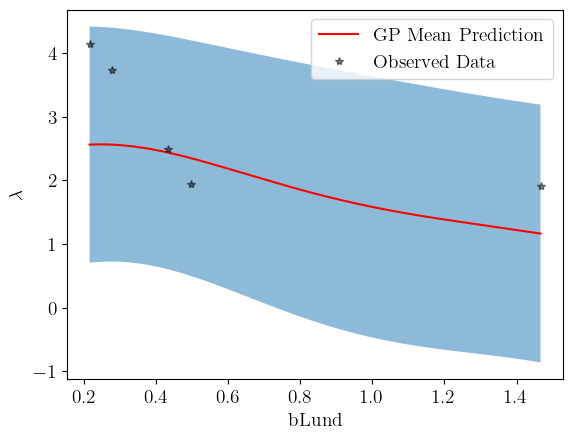

In [91]:
plot_model_param(model, 'bLund')

### Observe untrained (default) GP model parameters

In [92]:
def print_parameters(model):
    state_dict = model.state_dict()
    for param_name, param_tensor in state_dict.items():
        print(param_name, param_tensor)

In [93]:
print_parameters(model)

likelihood.noise_covar.raw_noise tensor([0.], dtype=torch.float64)
likelihood.noise_covar.raw_noise_constraint.lower_bound tensor(1.0000e-04, dtype=torch.float64)
likelihood.noise_covar.raw_noise_constraint.upper_bound tensor(inf, dtype=torch.float64)
mean_module.raw_constant tensor(0., dtype=torch.float64)
covar_module.raw_outputscale tensor(0., dtype=torch.float64)
covar_module.base_kernel.raw_lengthscale tensor([[0.]], dtype=torch.float64)
covar_module.base_kernel.raw_lengthscale_constraint.lower_bound tensor(0., dtype=torch.float64)
covar_module.base_kernel.raw_lengthscale_constraint.upper_bound tensor(inf, dtype=torch.float64)
covar_module.raw_outputscale_constraint.lower_bound tensor(0., dtype=torch.float64)
covar_module.raw_outputscale_constraint.upper_bound tensor(inf, dtype=torch.float64)


## Tune hyperparameters of GP model (train model)

We tune the hyperparameters by maximizing the marginal log likelihood (MLL) (i.e. treating -MLL as the loss and minimizing it)

$$ \text{MLL} = p_f(\mathbf{y} \mid \mathbf{X})=\int p(\mathbf{y} \mid f(\mathbf{X})) p(f(\mathbf{X}) \mid \mathbf{X}) d f $$

For the Gaussian process this equates to 
$$p(\mathbf{y} \mid \mathbf{X})=\mathcal{N}\left(\mathbf{y} \mid \mathbf{m}, \mathbf{K}+\sigma^2 \mathbf{I}\right)$$
$$ \mathcal{L}= - \text{MLL}$$

In [94]:
def train_model(model, train_x, train_y, n_epochs, print_=False):
    # Use the Adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    
    # Optimize the model
    model.train()
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        output = model(train_x)
        loss = - mll(output, train_y)
        if print_:
                print('Epoch %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f\n' % (
        epoch + 1, n_epochs, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
        loss.backward()
        optimizer.step()

In [95]:
train_model(model, train_x, train_y,25,print_=True)

Epoch 1/25 - Loss: 2.654   lengthscale: 0.693   noise: 0.693

Epoch 2/25 - Loss: 2.477   lengthscale: 0.744   noise: 0.744

Epoch 3/25 - Loss: 2.330   lengthscale: 0.798   noise: 0.797

Epoch 4/25 - Loss: 2.208   lengthscale: 0.853   noise: 0.851

Epoch 5/25 - Loss: 2.107   lengthscale: 0.909   noise: 0.904

Epoch 6/25 - Loss: 2.024   lengthscale: 0.965   noise: 0.955

Epoch 7/25 - Loss: 1.956   lengthscale: 1.022   noise: 1.004

Epoch 8/25 - Loss: 1.900   lengthscale: 1.077   noise: 1.048

Epoch 9/25 - Loss: 1.853   lengthscale: 1.132   noise: 1.086

Epoch 10/25 - Loss: 1.814   lengthscale: 1.185   noise: 1.119

Epoch 11/25 - Loss: 1.782   lengthscale: 1.236   noise: 1.145

Epoch 12/25 - Loss: 1.754   lengthscale: 1.285   noise: 1.164

Epoch 13/25 - Loss: 1.730   lengthscale: 1.331   noise: 1.177

Epoch 14/25 - Loss: 1.709   lengthscale: 1.374   noise: 1.183

Epoch 15/25 - Loss: 1.690   lengthscale: 1.415   noise: 1.183

Epoch 16/25 - Loss: 1.674   lengthscale: 1.453   noise: 1.177

E

In [96]:
print_parameters(model)

likelihood.noise_covar.raw_noise tensor([0.4383], dtype=torch.float64)
likelihood.noise_covar.raw_noise_constraint.lower_bound tensor(1.0000e-04, dtype=torch.float64)
likelihood.noise_covar.raw_noise_constraint.upper_bound tensor(inf, dtype=torch.float64)
mean_module.raw_constant tensor(1.9488, dtype=torch.float64)
covar_module.raw_outputscale tensor(1.5049, dtype=torch.float64)
covar_module.base_kernel.raw_lengthscale tensor([[1.4791]], dtype=torch.float64)
covar_module.base_kernel.raw_lengthscale_constraint.lower_bound tensor(0., dtype=torch.float64)
covar_module.base_kernel.raw_lengthscale_constraint.upper_bound tensor(inf, dtype=torch.float64)
covar_module.raw_outputscale_constraint.lower_bound tensor(0., dtype=torch.float64)
covar_module.raw_outputscale_constraint.upper_bound tensor(inf, dtype=torch.float64)


(2000,)


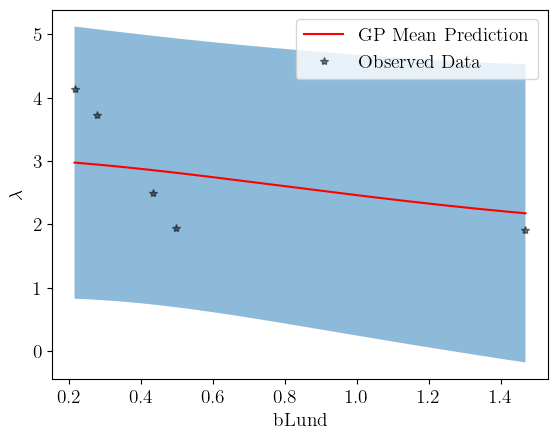

In [97]:
plot_model_param(model, 'bLund')

In [98]:
def get_observed_best_parameters(model):
    train_x = model.train_inputs[0].numpy()
    train_y = model.train_targets.numpy()
    observed_min = train_x[train_y.argmin()]
    param_names = list(PARAM_DICT.keys())
    param_names = [param_name.split(':')[1] for param_name in param_names]
    best_params_dict = {k: v for k, v in zip(param_names, observed_min)}
    return best_params_dict

## Validate the results and observe the data-MC agreement is bad at this point

1. Make the pythia card with the best parameters based on the Bayesian Optimization above
2. Run the pythia card with 300,000 events yielding a test.yoda validation output
3. convert yoda histograms to pandas dataframes, filter histograms and plot result agreement with data

In [99]:
def make_pythia_valid_card(best_parameters):
    
    cards_dir = os.path.join(os.getcwd(), "BO_Cards")
    filename = f"ALEPH_1996_S3486095_BO_card_valid.cmnd"
    file_path = os.path.join(cards_dir, filename)
    with open(file_path,'w') as f:
        first_block="""Main:numberOfEvents = 300000          ! number of events to generate
Next:numberShowEvent = 0           ! suppress full listing of first events
# random seed
Random:setSeed = on
Random:seed= 0
! 2) Beam parameter settings.
Beams:idA = 11                ! first beam,  e- = 11
Beams:idB = -11                ! second beam, e+ = -11
Beams:eCM = 91.2               ! CM energy of collision
# Pythia 8 settings for LEP
# Hadronic decays including b quarks, with ISR photons switched off
WeakSingleBoson:ffbar2gmZ = on
23:onMode = off
23:onIfAny = 1 2 3 4 5
PDF:lepton = off
SpaceShower:QEDshowerByL = off\n\n"""
        f.write(first_block)
        # f.write(f"Random:seed={indx+1}")

        # f.write("StringZ:aLund = {}\n\n".format(best_parameters["aLund"]))
        f.write("StringZ:bLund = {}\n\n".format(best_parameters["bLund"]))
        # f.write("StringZ:rFactC = {}\n\n".format(best_parameters["rFactC"]))
        # f.write("StringZ:rFactB = {}\n\n".format(best_parameters["rFactB"]))
        # f.write("StringZ:aExtraSQuark = {}\n\n".format(best_parameters["aExtraSQuark"]))
        # f.write("StringZ:aExtraDiquark = {}\n\n".format(best_parameters["aExtraDiquark"]))
        # f.write("StringPT:sigma = {}\n\n".format(best_parameters["sigma"]))
        # f.write("StringPT:enhancedFraction = {}\n\n".format(best_parameters["enhancedFraction"]))
        # f.write("StringPT:enhancedWidth = {}\n\n".format(best_parameters["enhancedWidth"]))
        # f.write("StringFlav:ProbStoUD = {}\n\n".format(best_parameters["ProbStoUD"]))
        # f.write("StringFlav:probQQtoQ = {}\n\n".format(best_parameters["probQQtoQ"]))
        # f.write("StringFlav:probSQtoQQ = {}\n\n".format(best_parameters["probSQtoQQ"]))
        # f.write("StringFlav:ProbQQ1toQQ0 = {}\n\n".format(best_parameters["ProbQQ1toQQ0"]))
        # f.write("TimeShower:alphaSvalue = {}\n\n".format(best_parameters["alphaSvalue"]))
        # f.write("TimeShower:pTmin = {}\n\n".format(best_parameters["pTmin"]))
def run_valid_card(best_parameters):
    
    # step 1: write .cmnd file 
    make_pythia_valid_card(best_parameters)
    #step 2 run main42 and rivet
    os.system("""./main42 BO_Cards/ALEPH_1996_S3486095_BO_card_valid.cmnd /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card_valid.fifo
    rivet -o ALEPH_1996_S3486095_hist_valid_0.yoda -a ALEPH_1996_S3486095 /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card_valid.fifo

    rm /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card_valid.fifo
    mv ALEPH_1996_S3486095_hist_valid_0.yoda ALEPH_YODAS_BayesOpt/""")

----

# Bayesian Optimization

Bayesian optimization is the optimization of a complex black box function (such as an objective function) $f(x)$ through iterative pointwise queries. The objective function is expensive, so it cannot be exhaustively evaluated. The function is also noisy, so repeated queries may yield different results.

We wish to find an optimal set of parameters $\mathbf{x}^*$ of the objective function

$$ \mathbf{x}^* = \text{arg max}_{\mathbf{x}\in \mathcal{R}^D} f(\mathbf{x})$$

In a nutshell, the algorithm works by forming a surrogate model $\hat{f}(x)$ by a GP of the objective function $f(x)$. 
$$ \hat{f}(\mathbf{x}) \sim \text{GP} (m(\mathbf{x}), k(\mathbf{x}))$$

We choose the next point through an acquisition function. We then evaluate and update the model, and repeat.

1. Construct a GP surrogate (regression) model $\hat{f}(x)$ of a function $f(x)$ using the sample $D = \{(x_i, f(x_i))\}_{i = 1}^n$
2. Select a new point that maximize an acquisition function $\alpha(x)$
$$
x_{new} = \arg\max\limits_x \alpha(x)
$$
3. Calculate $f(x_{new})$ at the new point.
4. Add the pair $(x_{new}, f(x_{new}))$ to the sample $D$.
5. Update the model $\hat{f}(x)$ and go to step 2.

## Expected Improvement

$$\operatorname{EI}(x)=\mathbb{E}\left[\max \left(f_{\text {best }}-f(x), 0\right)\right]$$

Assuming $f(x) \sim \mathcal{N}\left(\mu(x), \sigma(x)^2\right)$, the EI can be written as

$$\mathrm{EI}(x)=\left(\mu(x)-f_{\text {best }}-\xi\right) \Phi(Z)+\sigma(x) \phi(Z)$$

where

- $$\begin{array}{l}
Z=\frac{\mu(x)-f_{\text {bost }}-\xi}{\sigma(x)} \text { if } \sigma(x)>0 \\
Z=0 \text { if } \sigma(x)=0
\end{array}$$

- $\Phi$ is the CDF of the standard normal distribution, $\phi(x)$ is the PDF of the standard normal  distribution

- $\xi$ is a small non-negative number (often set to zero) to introduce a trade-off between exploitation and exploration. **the larger the $\xi$ the more exploration**

## Upper confidence Bound

The UCB acquisition function leverages both the prediction and the uncertainty to decide where to sample next.
$$ \text{UCB}(x) = \mu(x) + \kappa \sigma (x) $$

$\kappa$ is a tunable parameter that balances between exploration and exploitation. The higher $\kappa$, the more weight we're giving to giving to uncertainty in the decision process, promoting exploration.


In [100]:
def expected_improvement(model, observed_y, candidate_set):
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = model.predict(candidate_set)
        best_f = observed_y.min()
        
        mean = observed_pred.mean
        sigma = observed_pred.variance.sqrt()
        gamma = (best_f - mean) / sigma
        ei = sigma * (gamma * torch.distributions.Normal(0, 1).cdf(gamma) + torch.distributions.Normal(0, 1).log_prob(gamma).exp())
    return ei


def ucb(model, candidate_set, kappa=1.5):
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        pred = model.predict(candidate_set)
    return pred.mean + kappa * pred.stddev

In [101]:
x_candidates = make_x_candidates(PARAM_DICT,2)
print(x_candidates)
next_x = x_candidates[0]
a = torch.cat([train_x, next_x])
print(a)

tensor([[1.7513],
        [1.1298]], dtype=torch.float64)
tensor([1.4666, 0.4323, 0.4973, 0.2760, 0.2147, 1.7513], dtype=torch.float64)


In [102]:
x_candidates = make_x_candidates(PARAM_DICT,10)
x_candidates

tensor([[1.0477],
        [0.6952],
        [1.6141],
        [1.7262],
        [1.5187],
        [1.0303],
        [1.1082],
        [0.6854],
        [1.0450],
        [0.9717]], dtype=torch.float64)

In [103]:
def BayesOpt_one_param(model, 
                        train_x, 
                        train_y, 
                        n_iterations,
                        acquisition = 'EI',
                        retrain_gp=False,
                        print_=False,
                       save_model=False):
    # Use the Adam optimizer


    
    Monash_candidate = torch.tensor(list(MONASH_DICT.values()))
    next_y = true_objective_func(Monash_candidate.item())
    print(f'objective function at the Monash point = {next_y}')
    train_x = torch.cat([train_x, Monash_candidate])
    next_y = torch.tensor([next_y])
    train_y = torch.cat([train_y, next_y])
    model.set_train_data(inputs=train_x, targets=train_y, strict=False)
    train_model(model, train_x, train_y, 150, print_=print_)
    
    for iteration in range(n_iterations):
        model.eval()
        likelihood.eval()

        x_candidates = make_x_candidates(PARAM_DICT,1000)
        # x_candidates = make_sobol_candidates(PARAM_DICT,1000)
        if acquisition == 'EI':
            acq = expected_improvement(model, train_y, x_candidates)
        elif acquisition == 'UCB':
            acq = ucb(model, x_candidates)
        acq_argmax = acq.argmax()
        next_x = x_candidates[acq_argmax]
        next_y = true_objective_func(next_x.item())
        train_x = torch.cat([train_x, next_x])
        next_y = torch.tensor([next_y])

        print(f'epoch {iteration} next_x = {next_x}, next_y = {next_y}')
        train_y = torch.cat([train_y, next_y])

        model.set_train_data(inputs=train_x, targets=train_y, strict=False)
        
        # retrain model with updated data
        if retrain_gp:
            model.train()
            train_model(model, train_x, train_y, 150, print_=print_)

    train_size=train_x.shape[0]
    if save_model:
        path = f'models/GPytorch_all_params_model_Niter_{n_iterations}_trainsize_{train_size}_acq_{acquisition}.pth'
        torch.save(model.state_dict(), path)
        
        

In [104]:
BayesOpt_one_param(model=model, 
                    train_x=train_x, 
                    train_y=train_y, 
                    n_iterations=25, 
                    acquisition = 'EI',
                    retrain_gp=False,
                    print_=False,
                   save_model=False)


 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 20:47:20
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:00 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:01 elapsed)
Event 2200 (0:00:01 elapsed)
Event 2300 (0:00:01 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 20:47:22
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 20:47:22, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 16.49it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  12.480000  0.9984  0.044555  0.034613       156.0
1  0.005  0.010  23.360001  1.8688  0.175239  0.272542       292.0
2  0.010  0.015  21.200001  1.6960  0.261519  0.653684       265.0
3  0.015  0.020  16.240000  1.2992  0.280324  0.974392       203.0
4  0.020  0.025  13.680000  1.0944  0.303653  1.353952       171.0
 new data keys ['/

objective function = 1.3781753228317897
objective function at the Monash point = 1.3781753228317897

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  | 

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 20:47:26
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 20:47:28
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 20:47:28, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 16.89it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  10.240000  0.8192  0.035543  0.027097       128.0
1  0.005  0.010  24.959999  1.9968  0.185674  0.286739       312.0
2  0.010  0.015  21.760000  1.7408  0.266215  0.660264       272.0
3  0.015  0.020  17.280001  1.3824  0.305086  1.083438       216.0
4  0.020  0.025  14.320000  1.1456  0.322994  1.463554       179.0
 new data keys ['/

objective function = 1.3288963067725474
epoch 0 next_x = tensor([0.7446], dtype=torch.float64), next_y = tensor([1.3289], dtype=torch.float64)

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AA

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 20:47:31
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 20:47:33
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 20:47:33, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 16.90it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  17.120001  1.3696  0.055788  0.040836       214.0
1  0.005  0.010  24.000000  1.9200  0.177955  0.274111       300.0
2  0.010  0.015  21.360001  1.7088  0.265997  0.672378       267.0
3  0.015  0.020  16.000000  1.2800  0.277597  0.969755       200.0
4  0.020  0.025  11.120000  0.8896  0.246870  1.100386       139.0
 new data keys ['/

objective function = 2.7863824841719875
epoch 1 next_x = tensor([1.9969], dtype=torch.float64), next_y = tensor([2.7864], dtype=torch.float64)

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AA

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 20:47:37
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:00 elapsed)
Event 1000 (0:00:00 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:01 elapsed)
Event 2200 (0:00:01 elapsed)
Event 2300 (0:00:01 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 20:47:39
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 20:47:39, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 16.90it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  11.120000  0.8896  0.038741  0.029327       139.0
1  0.005  0.010  25.280001  2.0224  0.185475  0.282572       316.0
2  0.010  0.015  22.160000  1.7728  0.275239  0.693523       277.0
3  0.015  0.020  16.480000  1.3184  0.288239  1.015485       206.0
4  0.020  0.025  14.080000  1.1264  0.316091  1.425426       176.0
 new data keys ['/

objective function = 1.6481871602962823
epoch 2 next_x = tensor([1.1773], dtype=torch.float64), next_y = tensor([1.6482], dtype=torch.float64)

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AA

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 20:47:42
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 20:47:44
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 20:47:44, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 16.74it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   8.240000  0.6592  0.027196  0.019734       103.0
1  0.005  0.010  21.040001  1.6832  0.154764  0.237167       263.0
2  0.010  0.015  20.080000  1.6064  0.248004  0.621310       251.0
3  0.015  0.020  16.080000  1.2864  0.279987  0.981761       201.0
4  0.020  0.025  15.040000  1.2032  0.339625  1.540207       188.0
 new data keys ['/

objective function = 1.5710640924378796
epoch 3 next_x = tensor([0.6738], dtype=torch.float64), next_y = tensor([1.5711], dtype=torch.float64)

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AA

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 20:47:48
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:00 elapsed)
Event 1000 (0:00:00 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:01 elapsed)
Event 2200 (0:00:01 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 20:47:50
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 20:47:50, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 16.30it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  11.280000  0.9024  0.037875  0.027865       141.0
1  0.005  0.010  21.280001  1.7024  0.157209  0.241213       266.0
2  0.010  0.015  23.760000  1.9008  0.294997  0.742384       297.0
3  0.015  0.020  16.639999  1.3312  0.291035  1.024489       208.0
4  0.020  0.025  13.280000  1.0624  0.297030  1.334055       166.0
 new data keys ['/

objective function = 1.3428728434440527
epoch 4 next_x = tensor([0.8460], dtype=torch.float64), next_y = tensor([1.3429], dtype=torch.float64)

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AA

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 20:47:53
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 20:47:55
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 20:47:55, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 16.88it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  11.520000  0.9216  0.038167  0.028086       144.0
1  0.005  0.010  25.040001  2.0032  0.188239  0.292206       313.0
2  0.010  0.015  22.160000  1.7728  0.274480  0.689345       277.0
3  0.015  0.020  17.760000  1.4208  0.309041  1.083783       222.0
4  0.020  0.025  15.040000  1.2032  0.335072  1.499720       188.0
 new data keys ['/

objective function = 1.3222403957673057
epoch 5 next_x = tensor([0.7995], dtype=torch.float64), next_y = tensor([1.3222], dtype=torch.float64)

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AA

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 20:47:59
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:00 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:01 elapsed)
Event 2200 (0:00:01 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 20:48:01
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 20:48:01, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 16.35it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   8.800000  0.7040  0.028949  0.020932       110.0
1  0.005  0.010  21.760000  1.7408  0.161814  0.249689       272.0
2  0.010  0.015  21.280001  1.7024  0.265234  0.669910       266.0
3  0.015  0.020  17.920000  1.4336  0.314499  1.111014       224.0
4  0.020  0.025  13.200000  1.0560  0.296989  1.341574       165.0
 new data keys ['/

objective function = 1.5223577011659264
epoch 6 next_x = tensor([0.8018], dtype=torch.float64), next_y = tensor([1.5224], dtype=torch.float64)

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AA

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 20:48:04
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:01 elapsed)
Event 200 (0:00:01 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 20:48:06
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 20:48:06, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 16.45it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  11.920000  0.9536  0.042133  0.032082       149.0
1  0.005  0.010  22.799999  1.8240  0.169894  0.261739       285.0
2  0.010  0.015  21.200001  1.6960  0.263499  0.663818       265.0
3  0.015  0.020  18.240000  1.4592  0.320549  1.133623       228.0
4  0.020  0.025  12.080000  0.9664  0.270962  1.220594       151.0
 new data keys ['/

objective function = 1.473228693291652
epoch 7 next_x = tensor([0.9143], dtype=torch.float64), next_y = tensor([1.4732], dtype=torch.float64)

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAA

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 20:48:10
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 20:48:12
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 20:48:12, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 17.86it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  16.16  1.2928  0.053977  0.039653       202.0
1  0.005  0.010  26.24  2.0992  0.195182  0.301583       328.0
2  0.010  0.015  19.76  1.5808  0.245130  0.616155       247.0
3  0.015  0.020  17.76  1.4208  0.308284  1.077243       222.0
4  0.020  0.025  12.32  0.9856  0.273830  1.222645       154.0
 new data keys ['/REF/ALEPH_1996_S3486095/

objective function = 2.455727555116658
epoch 8 next_x = tensor([1.6999], dtype=torch.float64), next_y = tensor([2.4557], dtype=torch.float64)

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAA

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 20:48:16
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:00 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:01 elapsed)
Event 2200 (0:00:01 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 20:48:18
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 20:48:18, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 17.02it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  13.76  1.1008  0.045859  0.034506       172.0
1  0.005  0.010  21.84  1.7472  0.165049  0.258421       273.0
2  0.010  0.015  18.40  1.4720  0.228734  0.576822       230.0
3  0.015  0.020  15.92  1.2736  0.277008  0.970533       199.0
4  0.020  0.025  16.40  1.3120  0.368228  1.660255       205.0
 new data keys ['/REF/ALEPH_1996_S3486095/

objective function = 1.400852680696558
epoch 9 next_x = tensor([1.0421], dtype=torch.float64), next_y = tensor([1.4009], dtype=torch.float64)

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAA

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 20:48:21
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 20:48:23
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 20:48:23, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 17.98it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  10.480000  0.8384  0.036371  0.027517       131.0
1  0.005  0.010  21.680000  1.7344  0.163757  0.256469       271.0
2  0.010  0.015  20.719999  1.6576  0.255875  0.640560       259.0
3  0.015  0.020  17.840000  1.4272  0.309816  1.083555       223.0
4  0.020  0.025  14.720000  1.1776  0.329319  1.479522       184.0
 new data keys ['/

objective function = 1.3165262320426327
epoch 10 next_x = tensor([0.7723], dtype=torch.float64), next_y = tensor([1.3165], dtype=torch.float64)

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   A

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 20:48:27
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 20:48:29
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 20:48:29, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 18.27it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   9.920000  0.7936  0.033691  0.025462       124.0
1  0.005  0.010  20.879999  1.6704  0.159482  0.251240       261.0
2  0.010  0.015  20.799999  1.6640  0.259364  0.655796       260.0
3  0.015  0.020  19.280001  1.5424  0.334194  1.166974       241.0
4  0.020  0.025  14.320000  1.1456  0.318273  1.420675       179.0
 new data keys ['/

objective function = 1.4156406192060278
epoch 11 next_x = tensor([0.7697], dtype=torch.float64), next_y = tensor([1.4156], dtype=torch.float64)

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   A

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 20:48:33
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:01 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 20:48:35
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 20:48:35, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 17.29it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  10.400000  0.8320  0.035801  0.027018       130.0
1  0.005  0.010  23.840000  1.9072  0.177891  0.275138       298.0
2  0.010  0.015  21.040001  1.6832  0.262650  0.664110       263.0
3  0.015  0.020  17.040001  1.3632  0.298114  1.049813       213.0
4  0.020  0.025  14.080000  1.1264  0.316376  1.427502       176.0
 new data keys ['/

objective function = 1.3046215059160076
epoch 12 next_x = tensor([0.7741], dtype=torch.float64), next_y = tensor([1.3046], dtype=torch.float64)

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   A

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 20:48:38
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:01 elapsed)
Event 200 (0:00:01 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 20:48:40
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 20:48:40, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 17.38it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  11.280000  0.9024  0.038254  0.028320       141.0
1  0.005  0.010  22.400000  1.7920  0.170098  0.267146       280.0
2  0.010  0.015  19.280001  1.5424  0.238762  0.598909       241.0
3  0.015  0.020  18.000000  1.4400  0.316371  1.119445       225.0
4  0.020  0.025  14.720000  1.1776  0.330665  1.491722       184.0
 new data keys ['/

objective function = 1.3804954147649886
epoch 13 next_x = tensor([0.7717], dtype=torch.float64), next_y = tensor([1.3805], dtype=torch.float64)

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   A

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 20:48:44
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 20:48:46
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 20:48:46, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 17.27it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   9.920000  0.7936  0.036950  0.029042       124.0
1  0.005  0.010  22.639999  1.8112  0.172107  0.270588       283.0
2  0.010  0.015  19.680000  1.5744  0.246297  0.624864       246.0
3  0.015  0.020  18.639999  1.4912  0.324930  1.140087       233.0
4  0.020  0.025  14.880000  1.1904  0.331727  1.485178       186.0
 new data keys ['/

objective function = 1.6138956572533925
epoch 14 next_x = tensor([0.7739], dtype=torch.float64), next_y = tensor([1.6139], dtype=torch.float64)

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   A

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 20:48:50
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 20:48:52
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 20:48:53, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 13.53it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  11.76  0.9408  0.040453  0.030066       147.0
1  0.005  0.010  23.84  1.9072  0.177627  0.274720       298.0
2  0.010  0.015  17.68  1.4144  0.223113  0.570357       221.0
3  0.015  0.020  15.84  1.2672  0.272883  0.946049       198.0
4  0.020  0.025  13.52  1.0816  0.302788  1.361938       169.0
 new data keys ['/REF/ALEPH_1996_S3486095/

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 20:48:57
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:01 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:02 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:03 elapsed)
Event 2500 (0:00:03 elapsed)
Finished event loop at 2024-06-28 20:49:00
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 20:49:00, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 17.23it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  12.48  0.9984  0.041338  0.030116       156.0
1  0.005  0.010  22.40  1.7920  0.168722  0.264031       280.0
2  0.010  0.015  20.40  1.6320  0.255029  0.645757       255.0
3  0.015  0.020  18.24  1.4592  0.316149  1.103498       228.0
4  0.020  0.025  14.96  1.1968  0.334326  1.500489       187.0
 new data keys ['/REF/ALEPH_1996_S3486095/

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 20:49:04
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 20:49:06
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 20:49:06, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  8.54it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  8.59it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  11.360000  0.9088  0.039171  0.029713       142.0
1  0.005  0.010  23.120001  1.8496  0.173404  0.269983       289.0
2  0.010  0.015  20.879999  1.6704  0.258803  0.650071       261.0
3  0.015  0.020  18.240000  1.4592  0.318097  1.117446       228.0
4  0.020  0.025  12.880000  1.0304  0.288634  1.299188       161.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 20:49:11
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 20:49:13
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 20:49:13, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 17.13it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  10.720000  0.8576  0.038297  0.029656       134.0
1  0.005  0.010  24.160000  1.9328  0.179217  0.275376       302.0
2  0.010  0.015  21.600000  1.7280  0.265315  0.661077       270.0
3  0.015  0.020  17.120001  1.3696  0.300410  1.061029       214.0
4  0.020  0.025  13.040000  1.0432  0.292759  1.320200       163.0
 new data keys ['/

objective function = 1.2968525927413146
epoch 18 next_x = tensor([0.8333], dtype=torch.float64), next_y = tensor([1.2969], dtype=torch.float64)

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   A

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 20:49:18
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:00 elapsed)
Event 1000 (0:00:00 elapsed)
Event 1100 (0:00:00 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:01 elapsed)
Event 2200 (0:00:01 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 20:49:20
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 20:49:20, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



  0%|                                                     | 0/2 [00:00<?, ?it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  6.46it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  11.440000  0.9152  0.038686  0.028775       143.0
1  0.005  0.010  23.600000  1.8880  0.176590  0.274144       295.0
2  0.010  0.015  19.040001  1.5232  0.236191  0.593766       238.0
3  0.015  0.020  17.040001  1.3632  0.298501  1.053017       213.0
4  0.020  0.025  13.760000  1.1008  0.310569  1.407782       172.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 20:49:24
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 20:49:26
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 20:49:26, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 17.04it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  10.320000  0.8256  0.034651  0.025626       129.0
1  0.005  0.010  22.719999  1.8176  0.171543  0.268210       284.0
2  0.010  0.015  20.799999  1.6640  0.258092  0.649591       260.0
3  0.015  0.020  17.840000  1.4272  0.310339  1.087046       223.0
4  0.020  0.025  14.400000  1.1520  0.321287  1.439842       180.0
 new data keys ['/

objective function = 1.2541471114839393
epoch 20 next_x = tensor([0.8450], dtype=torch.float64), next_y = tensor([1.2541], dtype=torch.float64)

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   A

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 20:49:30
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:01 elapsed)
Event 200 (0:00:01 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:02 elapsed)
Event 1200 (0:00:02 elapsed)
Event 1300 (0:00:02 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:03 elapsed)
Event 2300 (0:00:03 elapsed)
Event 2400 (0:00:03 elapsed)
Event 2500 (0:00:03 elapsed)
Finished event loop at 2024-06-28 20:49:33
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 20:49:33, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 12.70it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  11.040000  0.8832  0.038828  0.029628       138.0
1  0.005  0.010  23.040001  1.8432  0.171600  0.263854       288.0
2  0.010  0.015  22.559999  1.8048  0.278460  0.696652       282.0
3  0.015  0.020  16.240000  1.2992  0.281784  0.984237       203.0
4  0.020  0.025  14.800000  1.1840  0.331089  1.488090       185.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 20:49:38
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 20:49:40
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 20:49:40, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  14.400000  1.1520  0.049927  0.037911       180.0
1  0.005  0.010  23.840000  1.9072  0.177569  0.274544       298.0
2  0.010  0.015  19.360001  1.5488  0.242483  0.615886       242.0
3  0.015  0.020  16.719999  1.3376  0.289304  1.007500       209.0
4  0.020  0.025  12.560000  1.0048  0.282437  1.275156       157.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 20:49:45
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:00 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:01 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 20:49:47
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 20:49:47, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 13.75it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  10.320000  0.8256  0.034901  0.025804       129.0
1  0.005  0.010  22.959999  1.8368  0.172942  0.269886       287.0
2  0.010  0.015  20.320000  1.6256  0.251063  0.629021       254.0
3  0.015  0.020  18.639999  1.4912  0.325007  1.141350       233.0
4  0.020  0.025  12.720000  1.0176  0.285585  1.288095       159.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF

Rivet 3.1.9 running on machine 6041484e02b7 (x86_64) at 2024-06-28 20:49:51
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:01 elapsed)
Event 200 (0:00:01 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:02 elapsed)
Event 1300 (0:00:02 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:03 elapsed)
Event 2300 (0:00:03 elapsed)
Event 2400 (0:00:03 elapsed)
Event 2500 (0:00:03 elapsed)
Finished event loop at 2024-06-28 20:49:54
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 20:49:54, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 16.12it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  10.320000  0.8256  0.036279  0.028435       129.0
1  0.005  0.010  23.440001  1.8752  0.177225  0.277704       293.0
2  0.010  0.015  20.480000  1.6384  0.252210  0.629808       256.0
3  0.015  0.020  18.240000  1.4592  0.315925  1.102286       228.0
4  0.020  0.025  14.880000  1.1904  0.333257  1.498467       186.0
 new data keys ['/

(2000,)


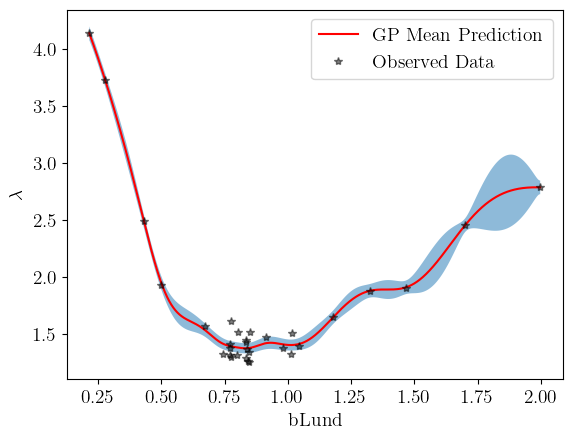

In [105]:
plot_model_param(model, 'bLund')

In [106]:
best_observed_params =get_observed_best_parameters(model)
best_observed_params

{'bLund': 0.8449961849050622}